## The Titanic Challenge
#### Which passengers survived the Titanic sinking?
The purpose of this notebook is to develop a machine learning classification model to predict which passengers survived the sinking of the RMS Titanic.  
\
The data used here is the training data for the famous "Titanic - Machine Learning from Disaster" challange available publicly on Kaggle: https://kaggle.com/competitions/titanic.  
In particular the publicly available "train.csv" file was used.

### About the dataset
In the used dataset 891 records and 10 features are provided. Each record is a passanger, and for each passenger the following information is provided:

|**FEATURE NAME**|**FEATURE DESCRIPTION**|
|----------------|-----------------------|
|PassengerId|Unique passenger identification number|
|Survived|0=not survived, 1=survived|
|Pclass|1 = 1st class, 2 = 2nd class, 3 = 3rd class|
|Name|Passenger name|
|Sex|male/Female|
|Age|Passenger age|
|SibSp|# of siblings / spouses aboard the Titanic|
|Parch|# of parents / children aboard the Titanic|
|Ticket|Ticket number|
|Fare|Passenger fare|
|Cabin|Cabin number|
|Embarked|Port of Embarkation, C = Cherbourg, Q = Queenstown, S = Southampton|

### Dataset and libraries loading

In [137]:
#importing libraries
import pandas as pd
import numpy as np

import seaborn as sns 
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix,ConfusionMatrixDisplay, accuracy_score


In [61]:
#dataset loading
filename = 'train.csv'
data = pd.read_csv(filename)

In [62]:
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### Explorative Data Analysis

In [63]:
data.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [64]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [65]:
data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


First let's analyze how survived passengers are distributed among the different classes.

In [66]:
data['Survived'].value_counts(normalize=True)

0    0.616162
1    0.383838
Name: Survived, dtype: float64

Survival rate is almost 40%, leading to a 40-60% balanced dataset. So we'll treat this as a balanced dataset when looking for the best model.

In [67]:
data['Pclass'].value_counts(normalize=True)

3    0.551066
1    0.242424
2    0.206510
Name: Pclass, dtype: float64

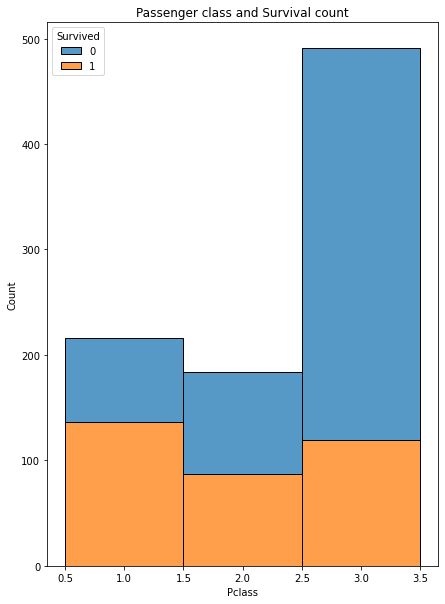

,Total,Survived,Rate
Pclass,,,
1,216.0,136.0,0.63
2,184.0,87.0,0.47
3,491.0,119.0,0.24


In [68]:
#visualizing survival rates for different passenger classes
fig, ax = plt.subplots(figsize=(7,10))
sns.histplot(ax=ax,data=data,x='Pclass',discrete=True,hue='Survived',multiple='stack')
plt.title('Passenger class and Survival count')
plt.show()

survival_rate_df = pd.DataFrame()
for class_type in data['Pclass'].sort_values().unique():
    survival_rate_df.loc[class_type,'Pclass'] = str(class_type)
    survival_rate_df.loc[class_type,'Total'] = data[data['Pclass']==class_type]['Pclass'].count()
    survival_rate_df.loc[class_type,'Survived'] = data[data['Pclass']==class_type]['Survived'].sum()
    survival_rate_df.loc[class_type,'Rate'] = (data[data['Pclass']==class_type]['Survived'].sum()/data[data['Pclass']==class_type]['Pclass'].count()).round(2)

survival_rate_df.set_index('Pclass')


Survival rate is lower for passengers in lower classes. This will surely be a fundamental feature for the model.  
\
Now let's check "Sex" and "Age" features, and how they relate to survival chances...

In [69]:
data['Sex'].value_counts()

male      577
female    314
Name: Sex, dtype: int64

In [70]:
survival_rate_sex = pd.DataFrame()
survival_rate_sex['Sex'] = data['Sex'].unique()
for i, sex in enumerate(data['Sex'].unique()):
    print(sex)
    survival_rate_sex.loc[i,'Total'] = data[data['Sex']==sex]['Sex'].count()
    survival_rate_sex.loc[i,'Survived'] = data[data['Sex']==sex]['Survived'].sum()
    survival_rate_sex.loc[i,'Rate'] = data[data['Sex']==sex]['Survived'].sum()/data[data['Sex']==sex]['Sex'].count()

survival_rate_sex.set_index('Sex')

male
female


,Total,Survived,Rate
Sex,,,
male,577.0,109.0,0.188908
female,314.0,233.0,0.742038


Also passenger sex has a clear influence on the survival rate. Female passengers had almost 75% survival chance.

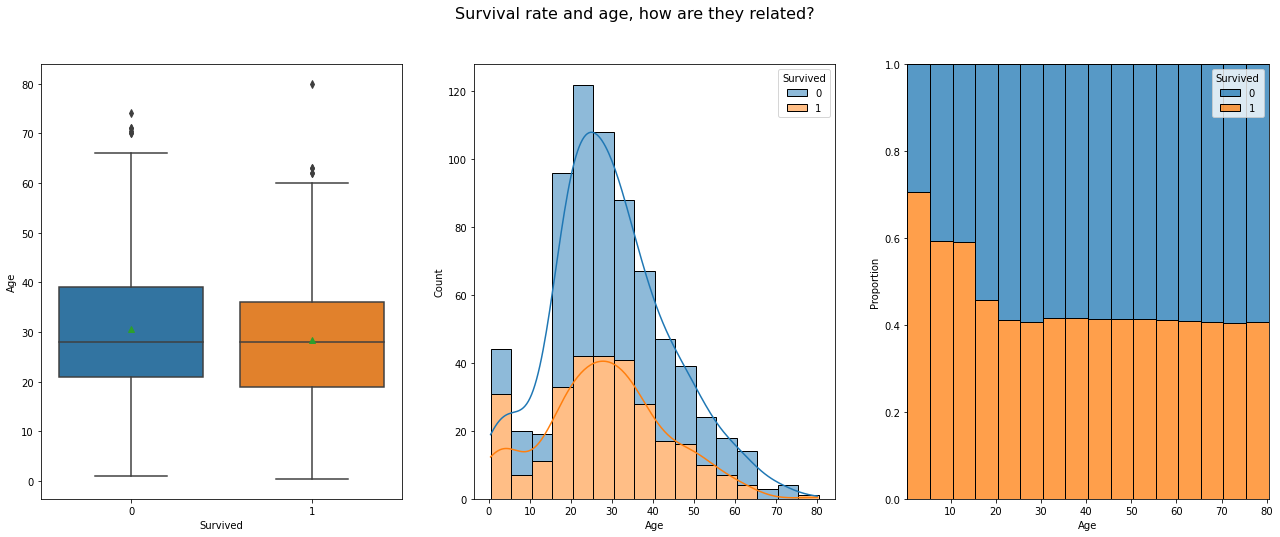

In [71]:
fig, axs = plt.subplots(nrows=1,ncols=3,figsize=(22,8))
sns.boxplot(ax=axs[0],data=data,x='Survived',y='Age',showmeans=True)
sns.histplot(ax=axs[1],data=data,x='Age',hue='Survived',binwidth=5,multiple='stack',kde=True)
sns.histplot(ax=axs[2],data=data,x='Age',hue='Survived',binwidth=5,stat='proportion',multiple='fill',bins=20,cumulative=True)
plt.suptitle('Survival rate and age, how are they related?', fontsize=16)
plt.show()

As it is clear from the third plot above, age influences survival rate when this is under 20. After this age the survival rate is about 40% for each class.  
\
To be sure this is not correlated to the passenger class let's check how age relates to the passenger class. Is age distribution the same for every class?

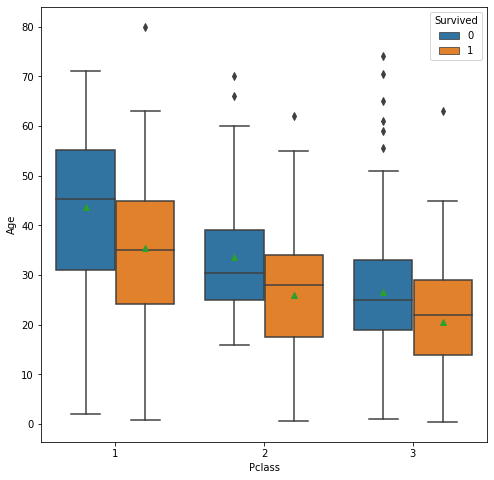

In [72]:
fig,ax = plt.subplots(figsize=(8,8))
sns.boxplot(ax=ax,data=data,x='Pclass',y='Age',hue='Survived',showmeans=True)
plt.show()

It can be noticed that the higher the class the higher the age, but the average age of survived passengers is lower for each of them.  
\
Now let's check how "SibSp" and "Parch" relate to the survival rate. The first one is the number of siblings and/or spouses on board for a certain passenger, while the second one represents the number of parents and/or childen on board for the examined passenger.

In [73]:
#number of siblings and/or spouses
data['SibSp'].value_counts()

0    608
1    209
2     28
4     18
3     16
8      7
5      5
Name: SibSp, dtype: int64

In [74]:
#number of parents and/or childen
data['Parch'].value_counts(sort=False)

0    678
1    118
2     80
5      5
3      5
4      4
6      1
Name: Parch, dtype: int64

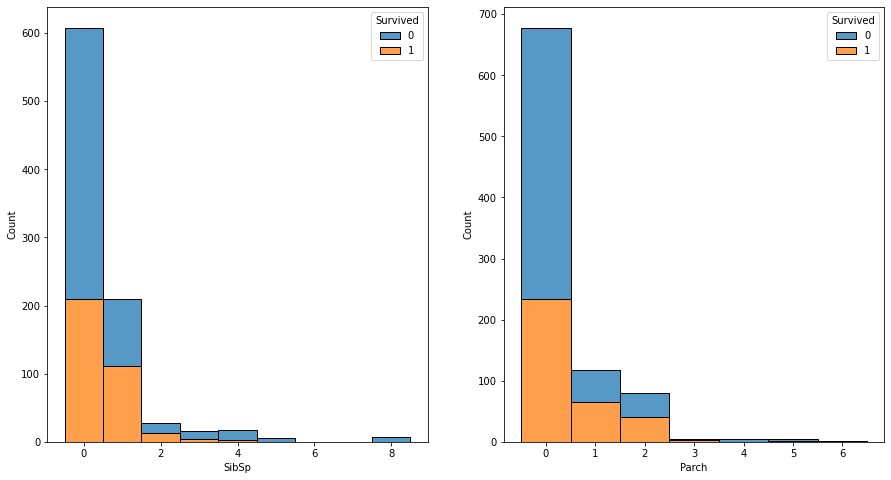

In [75]:
fig, axs = plt.subplots(nrows=1,ncols=2,figsize=(15,8))
sns.histplot(ax=axs[0],data=data,x='SibSp',hue='Survived',multiple='stack',discrete=True)
sns.histplot(ax=axs[1],data=data,x='Parch',hue='Survived',multiple='stack',discrete=True)
plt.show()

For both variables it seems that passengers with some relative on board had an higher survival chance. Let's check the survival rate for passengers with no relatives and compare it with the rate for passengers with relatives.

In [76]:
#SibSp
sibsp_df = pd.DataFrame(columns=['SibSp','Total','Survived','Rate'])
sibsp_df['SibSp'] = ['0','>=1']
sibsp_df.loc[0,'Total'] = data[data['SibSp']==0]['SibSp'].count()
sibsp_df.loc[1,'Total'] = data[data['SibSp']!=0]['SibSp'].count()
sibsp_df.loc[0,'Survived'] = data[data['SibSp']==0]['Survived'].sum()
sibsp_df.loc[1,'Survived'] = data[data['SibSp']!=0]['Survived'].sum()
sibsp_df.loc[0,'Rate'] = sibsp_df.loc[0,'Survived']/sibsp_df.loc[0,'Total']
sibsp_df.loc[1,'Rate'] = sibsp_df.loc[1,'Survived']/sibsp_df.loc[1,'Total']
sibsp_df

,SibSp,Total,Survived,Rate
0,0,608,210,0.345395
1,>=1,283,132,0.466431


In [77]:
#Parch
parch_df = pd.DataFrame(columns=['Parch','Total','Survived','Rate'])
parch_df['Parch'] = ['0','>=1']
parch_df.loc[0,'Total'] = data[data['Parch']==0]['Parch'].count()
parch_df.loc[1,'Total'] = data[data['Parch']!=0]['Parch'].count()
parch_df.loc[0,'Survived'] = data[data['Parch']==0]['Survived'].sum()
parch_df.loc[1,'Survived'] = data[data['Parch']!=0]['Survived'].sum()
parch_df.loc[0,'Rate'] = parch_df.loc[0,'Survived']/parch_df.loc[0,'Total']
parch_df.loc[1,'Rate'] = parch_df.loc[1,'Survived']/parch_df.loc[1,'Total']
parch_df

,Parch,Total,Survived,Rate
0,0,678,233,0.343658
1,>=1,213,109,0.511737


For both features, it seems that having no relatives on board takes to a survival chance of about 36%, that increases up to about 50% for more than one relative.  
\
For the feature engineering part, it could be interesting to simplify the two features by one-hot encoding both of them with "0" or "more than 1" relatives on board.

In [78]:
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In this analysis it is assumed that ticket numbers are random and have little or no influence on the survival rate. For this reason the next features to be checked are "Fare", "Cabin", "Embarked" and "Name".  
\
First let's check names. Looking at the first dataset rows we can hypothesize that, in general, the longer the name, the higher the passenger class. Let's check if this is true and how this is related to the survival rate.

In [79]:
name_length_df = pd.DataFrame()

In [80]:
name_length_df = data[['PassengerId','Survived','Pclass','Sex','Name']].copy(deep=True)
name_length_df['name_length'] = 0

for i, name in enumerate(name_length_df['Name']):
    name_length = len(name.split())
    name_length_df.loc[i,'name_length'] = name_length

name_length_df

,PassengerId,Survived,Pclass,Sex,Name,name_length
0,1,0,3,male,"Braund, Mr. Owen Harris",4
1,2,1,1,female,"Cumings, Mrs. John Bradley (Florence Briggs Th...",7
2,3,1,3,female,"Heikkinen, Miss. Laina",3
3,4,1,1,female,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",7
4,5,0,3,male,"Allen, Mr. William Henry",4
...,...,...,...,...,...,...
886,887,0,2,male,"Montvila, Rev. Juozas",3
887,888,1,1,female,"Graham, Miss. Margaret Edith",4
888,889,0,3,female,"Johnston, Miss. Catherine Helen ""Carrie""",5
889,890,1,1,male,"Behr, Mr. Karl Howell",4


In [81]:
name_length_df.groupby('Sex')['name_length','Survived'].mean()

/var/folders/yr/s44hgfd96_xdkrkb_9dz9rsc0000gn/T/ipykernel_5036/3262816325.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  name_length_df.groupby('Sex')['name_length','Survived'].mean()


,name_length,Survived
Sex,,
female,4.662420,0.742038
male,3.743501,0.188908


In [82]:
name_length_df.groupby('Pclass')['name_length','Survived'].mean()

/var/folders/yr/s44hgfd96_xdkrkb_9dz9rsc0000gn/T/ipykernel_5036/1773547891.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  name_length_df.groupby('Pclass')['name_length','Survived'].mean()


,name_length,Survived
Pclass,,
1,4.425926,0.629630
2,4.271739,0.472826
3,3.832994,0.242363


Name length and seems not so influent in class subdivision and survival rate, since first and second class passengers have names with quite similar length but different survival rates.  
During feature engineering phase we could consider including this variable and later decide if it is influent or not on the model.

In [83]:
data

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


Now we go on exploring the Cabin variable. Only a small portion of passengers had a cabin, and this results in lots of null values for this feature. Let's check whether having a cabin and its encoding influenced the survival chances.  
Here (https://www.encyclopedia-titanica.org/titanic-deckplans/) it can be found that different letters meant different decks. We can hipothesize that different decks could have meant different survival chances, especially because the accident occurred at night.

In [84]:
#renaming cabin column
data.rename(columns={'Cabin':'cabin_#'},inplace = True)

In [85]:
#creating cabin Y/N check column
data['cabin_y'] = np.NaN
for i, passenger in enumerate(data['cabin_#']):
    if pd.isnull(data.loc[i,'cabin_#'])==False:
        data.loc[i,'cabin_y'] = 1
    else:
        data.loc[i,'cabin_y'] = 0

data

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,cabin_#,Embarked,cabin_y
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,0.0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,1.0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,0.0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,1.0
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S,0.0
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S,1.0
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S,0.0
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C,1.0


In [86]:
#creating "cabin_deck" feature
data['cabin_deck'] = np.NaN
for i, passenger in enumerate(data['cabin_#']):
    if pd.isnull(data.loc[i,'cabin_#'])==False:
        data.loc[i,'cabin_deck'] = data.loc[i,'cabin_#'][0]
    else:
        data.loc[i,'cabin_deck'] = np.NaN
data

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,cabin_#,Embarked,cabin_y,cabin_deck
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,0.0,NaN
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,1.0,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,0.0,NaN
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,1.0,C
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S,0.0,NaN
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S,1.0,B
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S,0.0,NaN
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C,1.0,C


In [87]:
data['cabin_deck'].value_counts().to_frame()

,cabin_deck
C,59
B,47
D,33
E,32
A,15
F,13
G,4
T,1


In [88]:
#checking general survival rate with and without cabin
data.groupby('cabin_y')[['Survived']].mean().round(2)

,Survived
cabin_y,
0.0,0.30
1.0,0.67


In [89]:
#checking general survival rate for each deck
cabin_data = data.groupby('cabin_deck')['Survived'].mean().round(2).to_frame().reset_index()
cabin_data

,cabin_deck,Survived
0,A,0.47
1,B,0.74
2,C,0.59
3,D,0.76
4,E,0.75
5,F,0.62
6,G,0.50
7,T,0.00


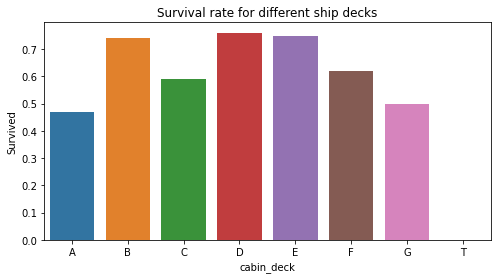

In [90]:
fig,ax = plt.subplots(figsize=(8,4))
sns.barplot(ax=ax,data=cabin_data, x='cabin_deck', y='Survived')
plt.title('Survival rate for different ship decks')
plt.show()

In [91]:
data.groupby('Pclass')['cabin_y'].sum().to_frame()

,cabin_y
Pclass,
1,176.0
2,16.0
3,12.0


It can be stated that in general, except for the passenger in cabin T (that was in the top deck), the survival rate for people with cabin was higher than the the one for people without cabin, and this is also conncted to passenger class. The decks' position in the ship was the following from top down: T, A, B, C, D, E, F, G. The bar plot above suggests that middle decks could have been safer. We keep this variable then and its importance will be checked before the model development phase.  
\
Now let's analyze the "Fare" variable.

In [92]:
data.sort_values(by='Fare').head(20)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,cabin_#,Embarked,cabin_y,cabin_deck
271,272,1,3,"Tornquist, Mr. William Henry",male,25.0,0,0,LINE,0.0000,NaN,S,0.0,NaN
597,598,0,3,"Johnson, Mr. Alfred",male,49.0,0,0,LINE,0.0000,NaN,S,0.0,NaN
302,303,0,3,"Johnson, Mr. William Cahoone Jr",male,19.0,0,0,LINE,0.0000,NaN,S,0.0,NaN
633,634,0,1,"Parr, Mr. William Henry Marsh",male,NaN,0,0,112052,0.0000,NaN,S,0.0,NaN
277,278,0,2,"Parkes, Mr. Francis ""Frank""",male,NaN,0,0,239853,0.0000,NaN,S,0.0,NaN
413,414,0,2,"Cunningham, Mr. Alfred Fleming",male,NaN,0,0,239853,0.0000,NaN,S,0.0,NaN
674,675,0,2,"Watson, Mr. Ennis Hastings",male,NaN,0,0,239856,0.0000,NaN,S,0.0,NaN
263,264,0,1,"Harrison, Mr. William",male,40.0,0,0,112059,0.0000,B94,S,1.0,B
466,467,0,2,"Campbell, Mr. William",male,NaN,0,0,239853,0.0000,NaN,S,0.0,NaN
732,733,0,2,"Knight, Mr. Robert J",male,NaN,0,0,239855,0.0000,NaN,S,0.0,NaN


It can be noticed that some passangers were given "complimentary tickets" by the companies they were working for, but also to follow the families they were working for as part of their "staff". (https://www.encyclopedia-titanica.org/community/threads/complimentary-tickets.8540/).

In [93]:
class_fares = data.groupby('Pclass')['Fare'].mean().to_frame()
class_fares

,Fare
Pclass,
1,84.154687
2,20.662183
3,13.675550


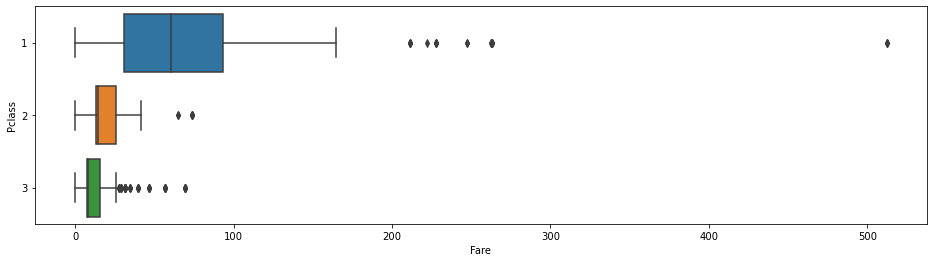

In [94]:
fig,ax = plt.subplots(figsize=(16,4))
sns.boxplot(ax=ax,data=data,x='Fare',y='Pclass',orient='h')
plt.show()

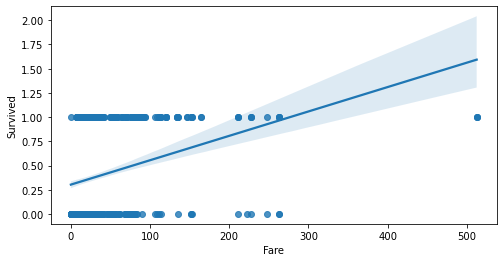

In [95]:
fig,ax = plt.subplots(figsize=(8,4))
sns.regplot(ax=ax,data=data,x='Fare',y='Survived')
plt.show()

As one could have expected, the higher the fare the higher the survival chance since it is connected to the passenger class.  
\
Last variable to be analyzed is "Embarked".

In [96]:
data['Embarked'].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

In [97]:
data.groupby('Embarked')['Survived'].mean()

Embarked
C    0.553571
Q    0.389610
S    0.336957
Name: Survived, dtype: float64

People that embarked in Cherbourg (C) had a consistently higher chance of survival respect to those passengers that embarked in Queensland (Q) or Southampton (S). Could thhis be related to class reasons?

In [98]:
data.groupby(['Embarked','Pclass'])['Embarked'].count().to_frame()


Embarked
Embarked Pclass          
C        1             85
         2             17
         3             66
Q        1              2
         2              3
         3             72
S        1            127
         2            164
         3            353

Yes, it could be given by the fact that half of the 85 (39%) out of the 216 first class passengers embarked in Cherbourg.

### Data cleaning
Missing values

In [99]:
#using info method to assess missing values
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  cabin_#      204 non-null    object 
 11  Embarked     889 non-null    object 
 12  cabin_y      891 non-null    float64
 13  cabin_deck   204 non-null    object 
dtypes: float64(3), int64(5), object(6)
memory usage: 97.6+ KB


Missing values are in the following features: Age, cabin_#, cabin_deck and Embarked. Cabin features depend on the cabin presence we cannot manipulate data other than with one-hot-encoding in feature engineering phase. "cabin_# and "cabin_y" can be deleted because the cabin presence is also marked by "cabin_deck". In addition, "Ticket" and "PassengerId" are also deleted.

In [100]:
#deleting extra columns
data.drop(columns=['cabin_#','cabin_y','Ticket','PassengerId'],inplace = True)
data

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,cabin_deck
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,S,NaN
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,C,C
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,S,NaN
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,S,C
4,0,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,S,NaN
...,...,...,...,...,...,...,...,...,...,...
886,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,13.0000,S,NaN
887,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,30.0000,S,B
888,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,23.4500,S,NaN
889,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,30.0000,C,C


In [101]:
#filling "cabin_deck" null values
data['cabin_deck'].fillna(value="NO",inplace=True)
data

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,cabin_deck
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,S,NO
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,C,C
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,S,NO
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,S,C
4,0,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,S,NO
...,...,...,...,...,...,...,...,...,...,...
886,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,13.0000,S,NO
887,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,30.0000,S,B
888,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,23.4500,S,NO
889,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,30.0000,C,C


In [102]:
#filling "Age" with last valid observation
#creating copy of data before the null filling of Age feature to compare the distribution before and after
data_before = data.copy(deep=True)

data['Age'].fillna(method='ffill',inplace=True)
data

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,cabin_deck
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,S,NO
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,C,C
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,S,NO
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,S,C
4,0,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,S,NO
...,...,...,...,...,...,...,...,...,...,...
886,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,13.0000,S,NO
887,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,30.0000,S,B
888,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,19.0,1,2,23.4500,S,NO
889,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,30.0000,C,C


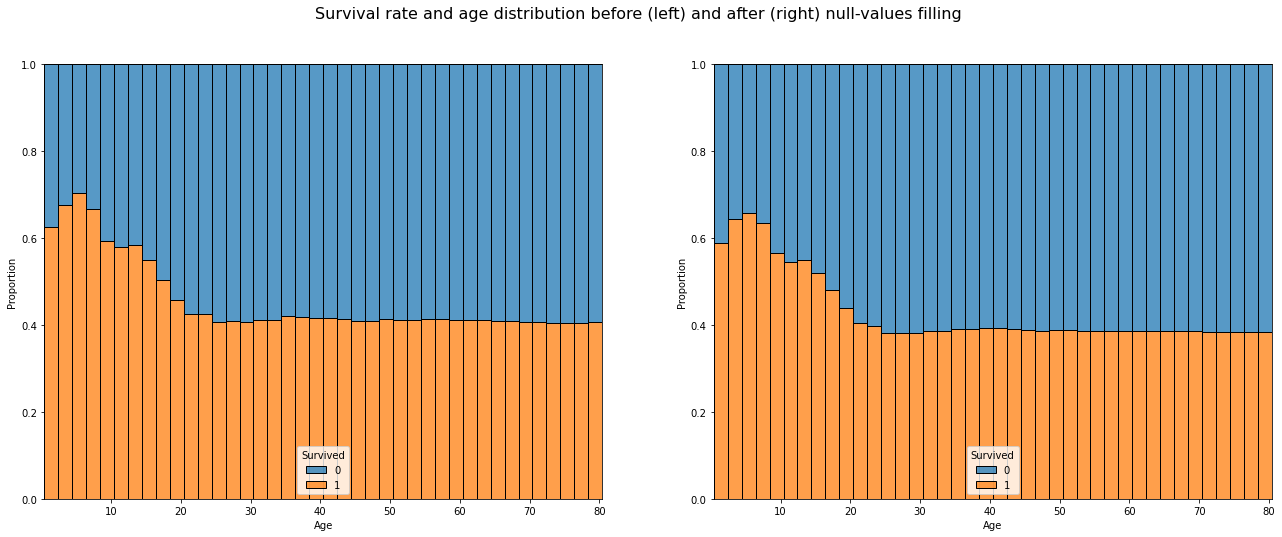

In [103]:
fig, axs = plt.subplots(nrows=1,ncols=2,figsize=(22,8))
sns.histplot(ax=axs[0],data=data_before,x='Age',hue='Survived',binwidth=2,stat='proportion',multiple='fill',cumulative=True)
sns.histplot(ax=axs[1],data=data,x='Age',hue='Survived',binwidth=2,stat='proportion',multiple='fill',cumulative=True)
plt.suptitle('Survival rate and age distribution before (left) and after (right) null-values filling', fontsize=16)
plt.show()

Age and survival rate before and after filling the null values is quite similar.

In [104]:
#filling "embarked" null values with the most common value
data['Embarked'].fillna(value='S',inplace=True)

In [105]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Survived    891 non-null    int64  
 1   Pclass      891 non-null    int64  
 2   Name        891 non-null    object 
 3   Sex         891 non-null    object 
 4   Age         891 non-null    float64
 5   SibSp       891 non-null    int64  
 6   Parch       891 non-null    int64  
 7   Fare        891 non-null    float64
 8   Embarked    891 non-null    object 
 9   cabin_deck  891 non-null    object 
dtypes: float64(2), int64(4), object(4)
memory usage: 69.7+ KB


### Feature engineering

In [106]:
#adding "name_length" feature and dropping "name"
data['name_length'] = name_length_df['name_length'].copy()
data.drop(columns='Name',inplace=True)
data

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,cabin_deck,name_length
0,0,3,male,22.0,1,0,7.2500,S,NO,4
1,1,1,female,38.0,1,0,71.2833,C,C,7
2,1,3,female,26.0,0,0,7.9250,S,NO,3
3,1,1,female,35.0,1,0,53.1000,S,C,7
4,0,3,male,35.0,0,0,8.0500,S,NO,4
...,...,...,...,...,...,...,...,...,...,...
886,0,2,male,27.0,0,0,13.0000,S,NO,3
887,1,1,female,19.0,0,0,30.0000,S,B,4
888,0,3,female,19.0,1,2,23.4500,S,NO,5
889,1,1,male,26.0,0,0,30.0000,C,C,4


In [107]:
#rearranging "SibSp" and "Parch" in a way that 0 means "no relatives" and 1 means "1 or more relatives"
data['SibSp'] = np.where(data['SibSp']>=1,1,0)
data['Parch'] = np.where(data['Parch']>=1,1,0)
data.rename(columns={'SibSp':'SibSP>=1'},inplace = True)
data.rename(columns={'Parch':'ParCh>=1'},inplace = True)
data

,Survived,Pclass,Sex,Age,SibSP>=1,ParCh>=1,Fare,Embarked,cabin_deck,name_length
0,0,3,male,22.0,1,0,7.2500,S,NO,4
1,1,1,female,38.0,1,0,71.2833,C,C,7
2,1,3,female,26.0,0,0,7.9250,S,NO,3
3,1,1,female,35.0,1,0,53.1000,S,C,7
4,0,3,male,35.0,0,0,8.0500,S,NO,4
...,...,...,...,...,...,...,...,...,...,...
886,0,2,male,27.0,0,0,13.0000,S,NO,3
887,1,1,female,19.0,0,0,30.0000,S,B,4
888,0,3,female,19.0,1,1,23.4500,S,NO,5
889,1,1,male,26.0,0,0,30.0000,C,C,4


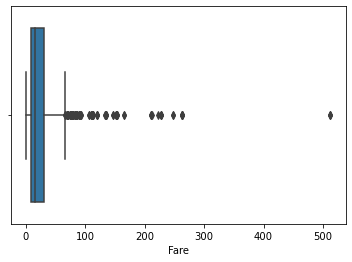

In [108]:
#checking for possible outliers in "Fare" feature
sns.boxplot(data=data, x='Fare')
plt.show()

In [109]:
data.sort_values(by='Fare',ascending=True)

,Survived,Pclass,Sex,Age,SibSP>=1,ParCh>=1,Fare,Embarked,cabin_deck,name_length
271,1,3,male,25.0,0,0,0.0000,S,NO,4
597,0,3,male,49.0,0,0,0.0000,S,NO,3
302,0,3,male,19.0,0,0,0.0000,S,NO,5
633,0,1,male,32.0,0,0,0.0000,S,NO,5
277,0,2,male,45.0,0,0,0.0000,S,NO,4
...,...,...,...,...,...,...,...,...,...,...
438,0,1,male,64.0,1,1,263.0000,S,C,3
341,1,1,female,24.0,1,1,263.0000,S,C,4
737,1,1,male,35.0,0,0,512.3292,C,B,4
258,1,1,female,35.0,0,0,512.3292,C,NO,3


Since the upper outliers are given by the pricing structure itself and they do not come from errors we keep them.

In [110]:
#defining new "Age_0-8" and "Age_9-16 features that one-hot encodes whether age is in those particular ranges
data['Age_0-8'] = np.NaN
data['Age_9-16'] = np.NaN
for i in data.index:
    if data.loc[i,'Age'] <= 16:
        if data.loc[i,'Age'] <= 8:
            data.loc[i,'Age_0-8'] = 1
            data.loc[i,'Age_9-16'] = 0
        else:
            data.loc[i,'Age_0-8'] = 0
            data.loc[i,'Age_9-16'] = 1
    else:
        data.loc[i,'Age_0-8'] = 0
        data.loc[i,'Age_9-16'] = 0

#### One-hot-encoding
Features that need to be one-hot-encoded are: "Sex", "Embarked" and "cabin_deck".

In [111]:
one_hot_encode_cols = data.dtypes[data.dtypes == object]  #filtering by string categoricals
one_hot_encode_cols = one_hot_encode_cols.index.to_list()
ohc_data = pd.get_dummies(data[one_hot_encode_cols])
data = pd.concat([data,ohc_data],axis=1)
data = data.drop(columns=one_hot_encode_cols)
data = data.drop(columns="Sex_male") #dropping one of the sex columns since it is a binary encoding
data

,Survived,Pclass,Age,SibSP>=1,ParCh>=1,Fare,name_length,Age_0-8,Age_9-16,Sex_female,...,Embarked_S,cabin_deck_A,cabin_deck_B,cabin_deck_C,cabin_deck_D,cabin_deck_E,cabin_deck_F,cabin_deck_G,cabin_deck_NO,cabin_deck_T
0,0,3,22.0,1,0,7.2500,4,0.0,0.0,0,...,1,0,0,0,0,0,0,0,1,0
1,1,1,38.0,1,0,71.2833,7,0.0,0.0,1,...,0,0,0,1,0,0,0,0,0,0
2,1,3,26.0,0,0,7.9250,3,0.0,0.0,1,...,1,0,0,0,0,0,0,0,1,0
3,1,1,35.0,1,0,53.1000,7,0.0,0.0,1,...,1,0,0,1,0,0,0,0,0,0
4,0,3,35.0,0,0,8.0500,4,0.0,0.0,0,...,1,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0,2,27.0,0,0,13.0000,3,0.0,0.0,0,...,1,0,0,0,0,0,0,0,1,0
887,1,1,19.0,0,0,30.0000,4,0.0,0.0,1,...,1,0,1,0,0,0,0,0,0,0
888,0,3,19.0,1,1,23.4500,5,0.0,0.0,1,...,1,0,0,0,0,0,0,0,1,0
889,1,1,26.0,0,0,30.0000,4,0.0,0.0,0,...,0,0,0,1,0,0,0,0,0,0


#### Min-max scaling
To avoid influencing the data structure, since we have little or no outliers, a simple min-max scaling is used to normalize data.

In [134]:
X = data.drop(columns='Survived')
y = data['Survived']
columns = X.columns.to_list()
mms = MinMaxScaler()

X_scaled = mms.fit_transform(X)
X = pd.DataFrame(X_scaled, columns=columns)
X


,Pclass,Age,SibSP>=1,ParCh>=1,Fare,name_length,Age_0-8,Age_9-16,Sex_female,Embarked_C,...,Embarked_S,cabin_deck_A,cabin_deck_B,cabin_deck_C,cabin_deck_D,cabin_deck_E,cabin_deck_F,cabin_deck_G,cabin_deck_NO,cabin_deck_T
0,1.0,0.271174,1.0,0.0,0.014151,0.090909,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.0,0.472229,1.0,0.0,0.139136,0.363636,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.321438,0.0,0.0,0.015469,0.000000,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.0,0.434531,1.0,0.0,0.103644,0.363636,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.434531,0.0,0.0,0.015713,0.090909,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0.5,0.334004,0.0,0.0,0.025374,0.000000,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
887,0.0,0.233476,0.0,0.0,0.058556,0.090909,0.0,0.0,1.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
888,1.0,0.233476,1.0,1.0,0.045771,0.181818,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
889,0.0,0.321438,0.0,0.0,0.058556,0.090909,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Correlation matrix and dimensionality reduction

In [114]:
correlation = data.corr()['Survived'].sort_values()
correlation

Pclass          -0.338481
cabin_deck_NO   -0.316912
Embarked_S      -0.149683
Age             -0.065571
cabin_deck_T    -0.026456
Age_9-16        -0.002457
Embarked_Q       0.003650
cabin_deck_G     0.016040
cabin_deck_A     0.022287
cabin_deck_F     0.057935
cabin_deck_C     0.114652
SibSP>=1         0.115867
cabin_deck_E     0.145321
ParCh>=1         0.147408
cabin_deck_D     0.150716
Age_0-8          0.151244
Embarked_C       0.168240
cabin_deck_B     0.175095
Fare             0.257307
name_length      0.276512
Sex_female       0.543351
Survived         1.000000
Name: Survived, dtype: float64

It can already be seen by studying the Pearson correlation between X variables and the target variable that some features have little or no correlation with survival chances.  
\
Let's now explore possible multicollinearities with the help of a heatmap representing the correlation matrix.

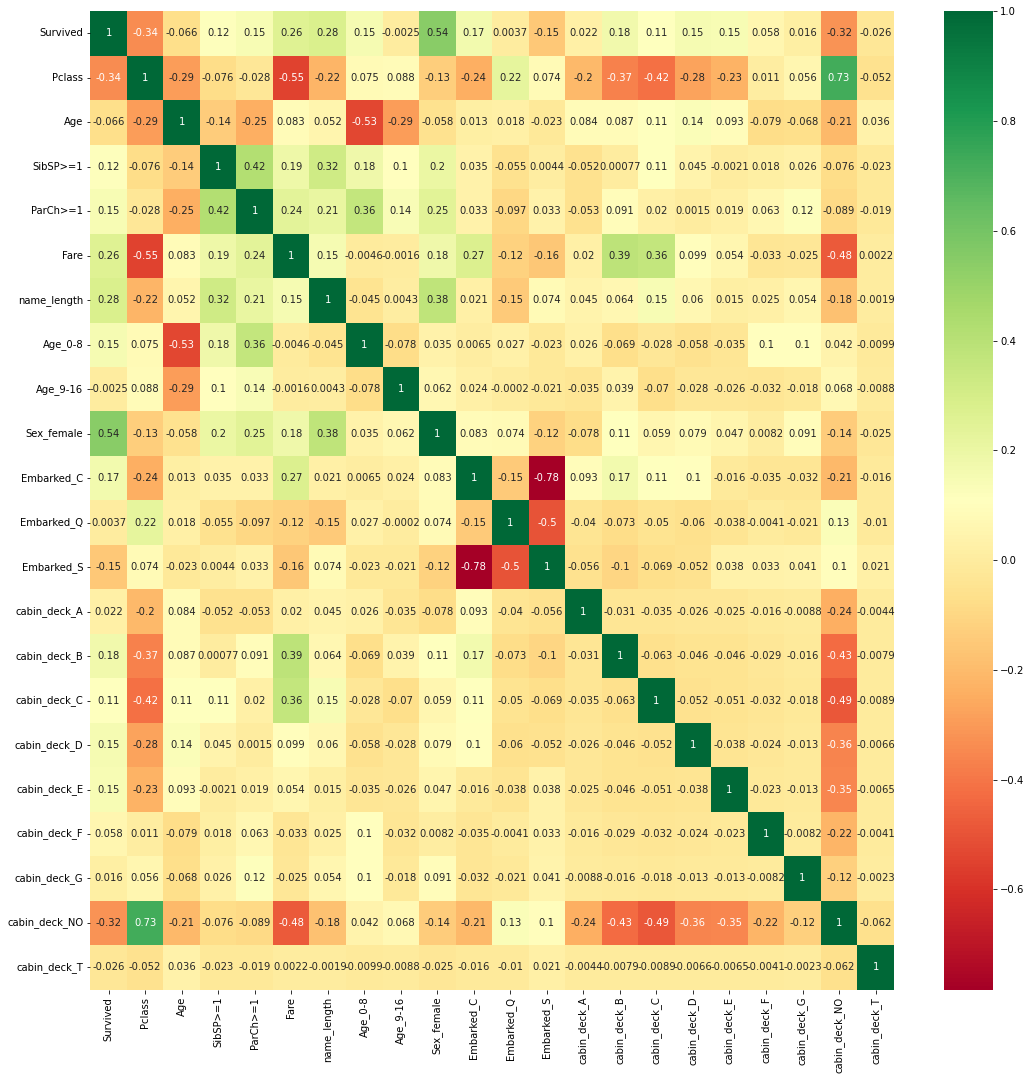

In [115]:
plt.figure(figsize=(18,18))
sns.heatmap(data.corr(),annot=True,cmap='RdYlGn')
plt.show()

We have strong relationships between "cabin_deck_NO" and "Pclass" and between the embarking port variables. Also, "Age_0-8" and "Age_9-16" are obviously connected to the "Age" variable. However, in general it can be noticed that indipendent variables are not strongly related to each other.  
\
Since the number of generated features is not too high, feature selection we'll be performed through embedded appproaches like Regularization.

## Modelling
Now we enter the model development phase. For all the developed models grid search cross validation will be used to tune hyper paramenters.  
Results are presented through a classification report and a confusion matrix. Moreover, for each model a dataframe that compares predictions and ground truth is is stored. This data is used to compare which passengers were not correctly classified by each model.

In [116]:
#defining random state
rs = 18

#splitting the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=rs)

#### Logistic regression

Fitting 5 folds for each of 6 candidates, totalling 30 fits
LogisticRegression(l1_ratio=0, max_iter=1000, penalty='elasticnet',
                   random_state=18, solver='saga')

Training accuracy score:  0.8033707865168539

Testing set classification report: 
              precision    recall  f1-score   support

           0       0.88      0.84      0.86       109
           1       0.77      0.81      0.79        70

    accuracy                           0.83       179
   macro avg       0.82      0.83      0.83       179
weighted avg       0.83      0.83      0.83       179



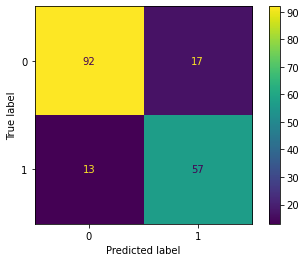

In [144]:
#defining parameters grid
param_grid = {
    'solver' : ['saga'],
    'penalty' : ['elasticnet'],
    'l1_ratio': [0, 0.2, 0.4, 0.6, 0.8, 1],
}
#defining estimator object
model = LogisticRegression(random_state=rs, max_iter=1000)
#defining grid search object
GS_LR = GridSearchCV(estimator=model, param_grid=param_grid, scoring='accuracy', cv=5, verbose=1)
#model fitting
GS_LR.fit(X_train,y_train)
print(GS_LR.best_estimator_)
#generating training predictions
train_preds = GS_LR.predict(X_train)
print('\nTraining accuracy score: ',accuracy_score(y_train, train_preds))
#generating test predictions
preds = GS_LR.predict(X_test)
#classification report
print('\nTesting set classification report: ')
print(classification_report(y_test, preds))
#plotting confusion matrix
cm = confusion_matrix(y_test,preds)
cm_disp = ConfusionMatrixDisplay(cm)
cm_disp.plot()
plt.show()

In [118]:
DF_LR = pd.DataFrame(GS_LR.predict(X),columns=['prediction'])
DF_LR['truth'] = y
DF_LR['outcome'] = np.NaN
for i in DF_LR.index:
    #print(DF.loc[i,'prediction'],DF.loc[i,'truth'])
    if DF_LR.loc[i,'prediction']==DF_LR.loc[i,'truth']:
        DF_LR.loc[i,'outcome'] = 'OK'
    else:
        DF_LR.loc[i,'outcome'] = 'NO'
DF_LR[DF_LR['outcome']=='NO']

,prediction,truth,outcome
6,1,0,NO
14,1,0,NO
17,0,1,NO
18,1,0,NO
21,0,1,NO
...,...,...,...
854,1,0,NO
869,0,1,NO
882,1,0,NO
885,1,0,NO


#### KNN algorithm

Fitting 5 folds for each of 22 candidates, totalling 110 fits
KNeighborsClassifier(n_neighbors=16)

Training accuracy score:  0.8047752808988764

Testing set classification report: 
              precision    recall  f1-score   support

           0       0.82      0.91      0.86       109
           1       0.83      0.70      0.76        70

    accuracy                           0.83       179
   macro avg       0.83      0.80      0.81       179
weighted avg       0.83      0.83      0.82       179



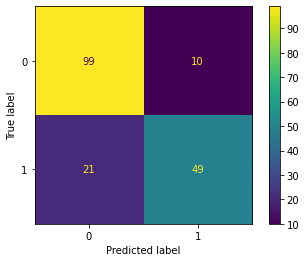

In [145]:
#defining parameters grid
param_grid = {
    'n_neighbors' : [10,11,12,13,14,15,16,17,18,19,20],
    'weights' : ['uniform','distance']
}
#defining estimator object
model = KNeighborsClassifier()
#defining grid search object
GS_KNN = GridSearchCV(estimator=model, param_grid=param_grid, scoring='accuracy', cv=5, verbose=1)
#model fitting
GS_KNN.fit(X_train,y_train)
print(GS_KNN.best_estimator_)
#generating training predictions
train_preds = GS_KNN.predict(X_train)
print('\nTraining accuracy score: ',accuracy_score(y_train, train_preds))
#generating test predictions
preds = GS_KNN.predict(X_test)
#classification report
print('\nTesting set classification report: ')
print(classification_report(y_test, preds))
#plotting confusion matrix
cm = confusion_matrix(y_test,preds)
cm_disp = ConfusionMatrixDisplay(cm)
cm_disp.plot()
plt.show()

In [120]:
DF_KNN = pd.DataFrame(GS_KNN.predict(X),columns=['prediction'])
DF_KNN['truth'] = y
DF_KNN['outcome'] = np.NaN
for i in DF_KNN.index:
    #print(DF.loc[i,'prediction'],DF.loc[i,'truth'])
    if DF_KNN.loc[i,'prediction']==DF_KNN.loc[i,'truth']:
        DF_KNN.loc[i,'outcome'] = 'OK'
    else:
        DF_KNN.loc[i,'outcome'] = 'NO'
DF_KNN[DF_KNN['outcome']=='NO']

,prediction,truth,outcome
2,0,1,NO
6,1,0,NO
10,0,1,NO
17,0,1,NO
18,1,0,NO
...,...,...,...
869,0,1,NO
872,1,0,NO
874,0,1,NO
885,1,0,NO


#### Support Vector Machines

Fitting 5 folds for each of 20 candidates, totalling 100 fits


SVC(C=0.5, kernel='poly')

Training accuracy score:  0.8300561797752809

Testing set classification report: 
              precision    recall  f1-score   support

           0       0.83      0.92      0.87       109
           1       0.85      0.71      0.78        70

    accuracy                           0.84       179
   macro avg       0.84      0.82      0.82       179
weighted avg       0.84      0.84      0.83       179



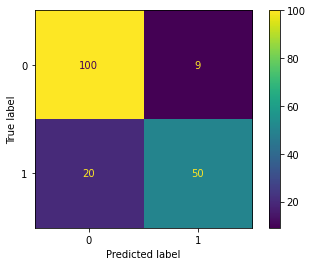

In [146]:
#defining parameters grid
param_grid = {
    'C' : [0.3,0.5,0.7,0.9,1],
    'kernel' : ['linear','poly','rbf','sigmoid']
}
#defining estimator object
model = SVC()
#defining grid search object
GS_SVC = GridSearchCV(estimator=model, param_grid=param_grid, scoring='accuracy', cv=5, verbose=1)
#model fitting
GS_SVC.fit(X_train,y_train)
print(GS_SVC.best_estimator_)
#generating training predictions
train_preds = GS_SVC.predict(X_train)
print('\nTraining accuracy score: ',accuracy_score(y_train, train_preds))
#generating test predictions
preds = GS_SVC.predict(X_test)
#classification report
print('\nTesting set classification report: ')
print(classification_report(y_test, preds))
#plotting confusion matrix
cm = confusion_matrix(y_test,preds)
cm_disp = ConfusionMatrixDisplay(cm)
cm_disp.plot()
plt.show()

In [122]:
DF_SVC = pd.DataFrame(GS_SVC.predict(X),columns=['prediction'])
DF_SVC['truth'] = y
DF_SVC['outcome'] = np.NaN
for i in DF_SVC.index:
    #print(DF.loc[i,'prediction'],DF.loc[i,'truth'])
    if DF_SVC.loc[i,'prediction']==DF_SVC.loc[i,'truth']:
        DF_SVC.loc[i,'outcome'] = 'OK'
    else:
        DF_SVC.loc[i,'outcome'] = 'NO'
DF_SVC[DF_SVC['outcome']=='NO']

,prediction,truth,outcome
8,0,1,NO
10,0,1,NO
14,1,0,NO
17,0,1,NO
18,1,0,NO
...,...,...,...
855,0,1,NO
857,0,1,NO
869,0,1,NO
882,1,0,NO


#### Decision Trees

Fitting 5 folds for each of 7600 candidates, totalling 38000 fits
DecisionTreeClassifier(max_depth=8, max_features=13, min_samples_leaf=15,
                       min_samples_split=5, random_state=18)

Training accuracy score:  0.827247191011236

Testing set classification report: 
              precision    recall  f1-score   support

           0       0.85      0.85      0.85       109
           1       0.77      0.77      0.77        70

    accuracy                           0.82       179
   macro avg       0.81      0.81      0.81       179
weighted avg       0.82      0.82      0.82       179



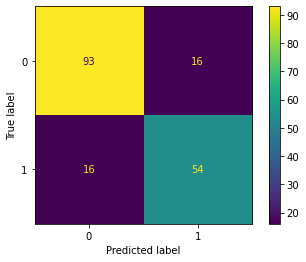

In [147]:
#defining parameters grid
param_grid = {
    'max_depth' : range(1,20),
    'max_features': range(1,21),
    'min_samples_leaf': [1,5,10,15,20],
    'min_samples_split': [5,10,15,20]
}
#defining estimator object
model = DecisionTreeClassifier(random_state=rs)
#defining grid search object
GS_DT = GridSearchCV(estimator=model, param_grid=param_grid, scoring='accuracy', cv=5, verbose=1)
#model fitting
GS_DT.fit(X_train,y_train)
print(GS_DT.best_estimator_)
#generating training predictions
train_preds = GS_DT.predict(X_train)
print('\nTraining accuracy score: ',accuracy_score(y_train, train_preds))
#generating test predictions
preds = GS_DT.predict(X_test)
#classification report
print('\nTesting set classification report: ')
print(classification_report(y_test, preds))
#plotting confusion matrix
cm = confusion_matrix(y_test,preds)
cm_disp = ConfusionMatrixDisplay(cm)
cm_disp.plot()
plt.show()

In [124]:
DF_DT = pd.DataFrame(GS_SVC.predict(X),columns=['prediction'])
DF_DT['truth'] = y
DF_DT['outcome'] = np.NaN
for i in DF_DT.index:
    #print(DF.loc[i,'prediction'],DF.loc[i,'truth'])
    if DF_DT.loc[i,'prediction']==DF_DT.loc[i,'truth']:
        DF_DT.loc[i,'outcome'] = 'OK'
    else:
        DF_DT.loc[i,'outcome'] = 'NO'
DF_DT[DF_DT['outcome']=='NO']

,prediction,truth,outcome
8,0,1,NO
10,0,1,NO
14,1,0,NO
17,0,1,NO
18,1,0,NO
...,...,...,...
855,0,1,NO
857,0,1,NO
869,0,1,NO
882,1,0,NO


#### Bagging

Fitting 5 folds for each of 96 candidates, totalling 480 fits
BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=5),
                  max_features=0.6, n_estimators=350, oob_score=True,
                  random_state=18)

Training accuracy score:  0.8862359550561798

Testing set classification report: 
              precision    recall  f1-score   support

           0       0.85      0.95      0.90       109
           1       0.91      0.74      0.82        70

    accuracy                           0.87       179
   macro avg       0.88      0.85      0.86       179
weighted avg       0.88      0.87      0.87       179



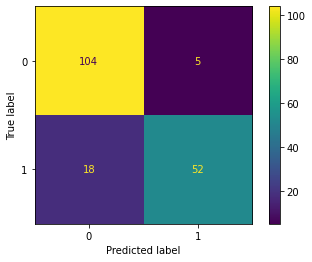

In [142]:
#defining parameters grid
param_grid = {
    'n_estimators': [300,350,400],
    'max_features': [0.3,0.4,0.5,0.6],
    'oob_score': [True,False],
    'base_estimator__max_depth' : [4,5,6,7]
}
#defining estimator object
model = BaggingClassifier(base_estimator=DecisionTreeClassifier(),random_state=rs,bootstrap=True)
#defining grid search object
GS_BAG = GridSearchCV(estimator=model, param_grid=param_grid, scoring='accuracy', cv=5, verbose=1, n_jobs=-1)
#model fitting
GS_BAG.fit(X_train,y_train)
print(GS_BAG.best_estimator_)
#generating training predictions
train_preds = GS_BAG.predict(X_train)
print('\nTraining accuracy score: ',accuracy_score(y_train, train_preds))
#generating test predictions
preds = GS_BAG.predict(X_test)
#classification report
print('\nTesting set classification report: ')
print(classification_report(y_test, preds))
#plotting confusion matrix
cm = confusion_matrix(y_test,preds)
cm_disp = ConfusionMatrixDisplay(cm)
cm_disp.plot()
plt.show()

In [126]:
DF_BAG = pd.DataFrame(GS_BAG.predict(X),columns=['prediction'])
DF_BAG['truth'] = y
DF_BAG['outcome'] = np.NaN
for i in DF_BAG.index:
    #print(DF.loc[i,'prediction'],DF.loc[i,'truth'])
    if DF_BAG.loc[i,'prediction']==DF_BAG.loc[i,'truth']:
        DF_BAG.loc[i,'outcome'] = 'OK'
    else:
        DF_BAG.loc[i,'outcome'] = 'NO'
DF_BAG[DF_BAG['outcome']=='NO']

,prediction,truth,outcome
2,0,1,NO
7,1,0,NO
8,0,1,NO
18,1,0,NO
19,0,1,NO
...,...,...,...
828,0,1,NO
838,0,1,NO
854,1,0,NO
855,0,1,NO


#### Random Forest

Fitting 5 folds for each of 48 candidates, totalling 240 fits
RandomForestClassifier(max_depth=5, max_features='sqrt', n_estimators=125,
                       random_state=18)

Training accuracy score:  0.8595505617977528

Testing set classification report: 
              precision    recall  f1-score   support

           0       0.87      0.97      0.92       109
           1       0.95      0.77      0.85        70

    accuracy                           0.89       179
   macro avg       0.91      0.87      0.88       179
weighted avg       0.90      0.89      0.89       179



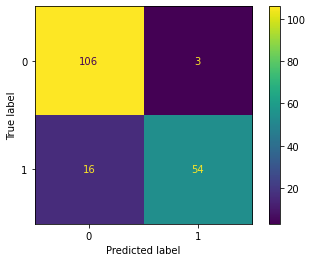

In [139]:
#defining parameters grid
param_grid = {
    'n_estimators': [75,100,125,150],
    'max_depth' : [4,5,6,7],
    'max_features': [None, "sqrt", "log2"],
    #'bootstrap': [True,False],
    #'oob_score': [True,False]
}
#defining estimator object
model = RandomForestClassifier(random_state=rs)
#defining grid search object
GS_RF = GridSearchCV(estimator=model, param_grid=param_grid, scoring='accuracy', cv=5, verbose=1, n_jobs=-1)
#model fitting
GS_RF.fit(X_train,y_train)
print(GS_RF.best_estimator_)
#generating training predictions
train_preds = GS_RF.predict(X_train)
print('\nTraining accuracy score: ',accuracy_score(y_train, train_preds))
#generating test predictions
preds = GS_RF.predict(X_test)
#classification report
print('\nTesting set classification report: ')
print(classification_report(y_test, preds))
#plotting confusion matrix
cm = confusion_matrix(y_test,preds)
cm_disp = ConfusionMatrixDisplay(cm)
cm_disp.plot()
plt.show()

In [140]:
DF_RF = pd.DataFrame(GS_RF.predict(X),columns=['prediction'])
DF_RF['truth'] = y
DF_RF['outcome'] = np.NaN
for i in DF_RF.index:
    #print(DF.loc[i,'prediction'],DF.loc[i,'truth'])
    if DF_RF.loc[i,'prediction']==DF_RF.loc[i,'truth']:
        DF_RF.loc[i,'outcome'] = 'OK'
    else:
        DF_RF.loc[i,'outcome'] = 'NO'
DF_RF[DF_RF['outcome']=='NO']

,prediction,truth,outcome
2,0,1,NO
8,0,1,NO
17,0,1,NO
18,1,0,NO
19,0,1,NO
...,...,...,...
854,1,0,NO
855,0,1,NO
857,0,1,NO
869,0,1,NO


#### Boosting

Fitting 5 folds for each of 405 candidates, totalling 2025 fits
GradientBoostingClassifier(n_estimators=80, random_state=18, subsample=0.5)

Training accuracy score:  0.8904494382022472

Testing set classification report: 
              precision    recall  f1-score   support

           0       0.87      0.93      0.90       109
           1       0.87      0.79      0.83        70

    accuracy                           0.87       179
   macro avg       0.87      0.86      0.86       179
weighted avg       0.87      0.87      0.87       179



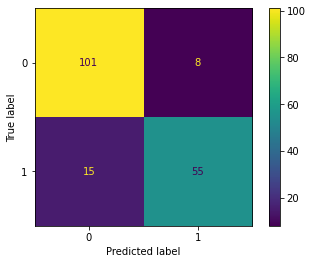

In [143]:
#defining parameters grid
param_grid = {
    'n_estimators': [50,60,70,80,90],
    'max_depth' : [2,3,4],
    'learning_rate': [0.1, 0.2, 0.3],
    'subsample': [0.25, 0.5, 1],
    'max_features': [None, "sqrt", "log2"]
}
#defining estimator object
model = GradientBoostingClassifier(random_state=rs)
#defining grid search object
GS_GBC = GridSearchCV(estimator=model, param_grid=param_grid, scoring='accuracy', cv=5, verbose=1, n_jobs=-1)
#model fitting
GS_GBC.fit(X_train,y_train)
print(GS_GBC.best_estimator_)
#generating training predictions
train_preds = GS_GBC.predict(X_train)
print('\nTraining accuracy score: ',accuracy_score(y_train, train_preds))
#generating test predictions
preds = GS_GBC.predict(X_test)
#classification report
print('\nTesting set classification report: ')
print(classification_report(y_test, preds))
#plotting confusion matrix
cm = confusion_matrix(y_test,preds)
cm_disp = ConfusionMatrixDisplay(cm)
cm_disp.plot()
plt.show()

In [130]:
DF_GBC = pd.DataFrame(GS_GBC.predict(X),columns=['prediction'])
DF_GBC['truth'] = y
DF_GBC['outcome'] = np.NaN
for i in DF_GBC.index:
    #print(DF.loc[i,'prediction'],DF.loc[i,'truth'])
    if DF_GBC.loc[i,'prediction']==DF_GBC.loc[i,'truth']:
        DF_GBC.loc[i,'outcome'] = 'OK'
    else:
        DF_GBC.loc[i,'outcome'] = 'NO'
DF_GBC[DF_GBC['outcome']=='NO']

,prediction,truth,outcome
2,0,1,NO
7,1,0,NO
8,0,1,NO
14,1,0,NO
18,1,0,NO
...,...,...,...
838,0,1,NO
852,1,0,NO
854,1,0,NO
855,0,1,NO


In [148]:
outcomes_df = pd.DataFrame()
outcomes_df['LR'] = DF_LR['outcome']
outcomes_df['KNN'] = DF_KNN['outcome']
outcomes_df['SVC'] = DF_SVC['outcome']
outcomes_df['DT'] = DF_DT['outcome']
outcomes_df['BAG'] = DF_BAG['outcome']
outcomes_df['RF'] = DF_RF['outcome']
outcomes_df['GBC'] = DF_GBC['outcome']
outcomes_df['class_fail_count'] = np.NaN

for i in outcomes_df.index:
    count = 0
    for j in outcomes_df.loc[i,:]:
        if j == 'NO':
            count += 1
    outcomes_df.loc[i,'class_fail_count'] = count
        
#number of observations that were mis-classified by all developed models
no_model = outcomes_df[outcomes_df['class_fail_count']==7].shape[0]
print(no_model)
#number of observations that were mis-classified by all but one developed model
one_model = outcomes_df[outcomes_df['class_fail_count']==6].shape[0]
print(one_model)

56
16


72 out of the 891 observations were not correctly classified by none or just one of the developed models (8%).

## Conclusions and possible steps for improvement

By comparing performance of all the developed models, it can be noticed that ensemble methods did raise bot test and train accuracy respect to the simple classification algorithms, on average by 5/6%. This effective but little increase could be due to the fact that cross-validation and grid search already lead to accurate results (no overfitting), making it difficult for ensemble methods to increase performance more than the measured levels of accuracy.  
\
All ensemble based models had similar scores, but considering both training and testing accuracy, precision-recall valuees, and the overall performance on the whole dataset, he best model however was the Gradient Boosting model, with hyper parameters found through cross-validation, it mis-classifies 101 observations out of the total dataset.  
It has to be point out that we didn't consider different costs of misclassification for the two classes. We could imagine that if we want to prioritize human life like in this case, it is better to classify a passenger as "at risk" rather than classifying them as "safer" (higher survival chances).  
Given this, it can be said that the GBC technique is ok since it has a 93% recall for class 0, meaning that few passengers were classified as "Survived" when they were not. On the other side, recall for class 1 is only 79%. This suggests that the model tends to 'prefer' class 0 and further improvements could be tried to adress this. One suggestion could be trying different class weights when splitting.

## The Challenge

In [195]:
#challenge dataset loading
filename = 'test.csv'
ch_data = pd.read_csv(filename)

#generating prediction dataset
pred_data = pd.DataFrame(columns=['PassengerId','Survived'])
pred_data['PassengerId'] = ch_data['PassengerId']
pred_data['Survived'] = np.NaN
pred_data

,PassengerId,Survived
0,892,NaN
1,893,NaN
2,894,NaN
3,895,NaN
4,896,NaN
...,...,...
413,1305,NaN
414,1306,NaN
415,1307,NaN
416,1308,NaN


In [196]:
ch_data

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...
413,1305,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S
414,1306,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C
415,1307,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S
416,1308,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S


In [197]:
ch_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


Missing values are in "Age", "Fare" and "Cabin" features

#### Challange dataset transformation
Here the challenge dataset has to go through the same transformations that the training one went through.

In [198]:
#renaming cabin column
ch_data.rename(columns={'Cabin':'cabin_#'},inplace = True)

#creating cabin Y/N check column
ch_data['cabin_y'] = np.NaN
for i, passenger in enumerate(ch_data['cabin_#']):
    if pd.isnull(ch_data.loc[i,'cabin_#'])==False:
        ch_data.loc[i,'cabin_y'] = 1
    else:
        ch_data.loc[i,'cabin_y'] = 0

#creating "cabin_deck" feature
ch_data['cabin_deck'] = np.NaN
for i, passenger in enumerate(ch_data['cabin_#']):
    if pd.isnull(ch_data.loc[i,'cabin_#'])==False:
        ch_data.loc[i,'cabin_deck'] = ch_data.loc[i,'cabin_#'][0]
    else:
        ch_data.loc[i,'cabin_deck'] = np.NaN
        
#deleting extra columns
ch_data.drop(columns=['cabin_#','cabin_y','Ticket','PassengerId'],inplace = True)

#filling "cabin_deck" null values
ch_data['cabin_deck'].fillna(value="NO",inplace=True)

#filling "Age" with last valid observation
ch_data['Age'].fillna(method='ffill',inplace=True)

#adding "name_length" feature and dropping "Name"
ch_data['name_length'] = np.NaN
for i in ch_data['Name'].index:
    ch_data.loc[i,'name_length'] = len(ch_data.loc[i,'Name'].split())
ch_data.drop(columns='Name',inplace=True)
ch_data

#average fare for Pclass = 3 of the passenger
fare = class_fares.iloc[2,0]
#filling fare missing value
ch_data['Fare'].fillna(value=fare,inplace=True)

#rearranging "SibSp" and "Parch" in a way that 0 means "no relatives" and 1 means "1 or more relatives"
ch_data['SibSp'] = np.where(ch_data['SibSp']>=1,1,0)
ch_data['Parch'] = np.where(ch_data['Parch']>=1,1,0)
ch_data.rename(columns={'SibSp':'SibSP>=1'},inplace = True)
ch_data.rename(columns={'Parch':'ParCh>=1'},inplace = True)

#defining new "Age_0-8" and "Age_9-16 features that one-hot encodes whether age is in those particular ranges
ch_data['Age_0-8'] = np.NaN
ch_data['Age_9-16'] = np.NaN
for i in ch_data.index:
    if ch_data.loc[i,'Age'] <= 16:
        if ch_data.loc[i,'Age'] <= 8:
            ch_data.loc[i,'Age_0-8'] = 1
            ch_data.loc[i,'Age_9-16'] = 0
        else:
            ch_data.loc[i,'Age_0-8'] = 0
            ch_data.loc[i,'Age_9-16'] = 1
    else:
        ch_data.loc[i,'Age_0-8'] = 0
        ch_data.loc[i,'Age_9-16'] = 0

#one-hot encoding
one_hot_encode_cols = ch_data.dtypes[ch_data.dtypes == object]  #filtering by string categoricals
one_hot_encode_cols = one_hot_encode_cols.index.to_list()
ch_ohc_data = pd.get_dummies(ch_data[one_hot_encode_cols])
ch_data = pd.concat([ch_data,ch_ohc_data],axis=1)
ch_data = ch_data.drop(columns=one_hot_encode_cols)
ch_data = ch_data.drop(columns="Sex_male") #dropping one of the sex columns since it is a binary encoding

#adding deck T column
ch_data['cabin_deck_T'] = 0

#min-max scaling
ch_X = ch_data
columns = ch_X.columns.to_list()
ch_X_scaled = mms.transform(ch_X)
ch_X = pd.DataFrame(ch_X_scaled, columns=columns)
ch_X

,Pclass,Age,SibSP>=1,ParCh>=1,Fare,name_length,Age_0-8,Age_9-16,Sex_female,Embarked_C,...,Embarked_S,cabin_deck_A,cabin_deck_B,cabin_deck_C,cabin_deck_D,cabin_deck_E,cabin_deck_F,cabin_deck_G,cabin_deck_NO,cabin_deck_T
0,1.0,0.428248,0.0,0.0,0.015282,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,1.0,0.585323,1.0,0.0,0.013663,0.181818,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.5,0.773813,0.0,0.0,0.018909,0.090909,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,1.0,0.334004,0.0,0.0,0.016908,0.000000,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,1.0,0.271174,1.0,1.0,0.023984,0.272727,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,1.0,0.346569,0.0,0.0,0.015713,0.000000,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
414,0.0,0.484795,0.0,0.0,0.212559,0.181818,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
415,1.0,0.478512,0.0,0.0,0.014151,0.090909,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
416,1.0,0.478512,0.0,0.0,0.015713,0.000000,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [199]:
#best model
best_model = GS_GBC

#generating prediction
ch_pred = best_model.predict(ch_X)

In [201]:
pred_data['Survived'] = ch_pred

In [202]:
pred_data

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,0
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


In [203]:
file_title = "results.csv"
with open(file_title,"w") as db_file:
    db_file.write(pred_data.to_csv(index=False))